# III. Plotting time-series with NRT Package

---

We can now start analyzing the VI time-series with the NRT package. The objective is to fully understand how this tool works, by visualizing through plots the time-series values, the modeling by harmonious function and the more or less early detections depending on the methods used.

---
## 0. Install NRT package (optional)

Depending of your Python environment, you can install the NRT Package in different ways. Here, we choose to install the package in our current session (uncomment the line of code if necessary).

In [1]:
!pip install nrt

---

## 1. Import librairies
First, we import some basic librairies.

In [2]:
import os
import pickle

Here are imported all detection methods avalaible in the NRT package:
- **EWMA**: Exponentially Weighted Moving Average
- **IQR**: InterQuantile Range
- **CCDC**: Continuous Change Detection and Classification of land cover
- **CuSum**: Cumulative Sum of Residual
- **MoSum**: Moving Sum of Residuals

In [3]:
from nrt.monitor.ewma import EWMA
from nrt.monitor.iqr import IQR
from nrt.monitor.ccdc import CCDC
from nrt.monitor.cusum import CuSum
from nrt.monitor.mosum import MoSum

We also import the spatial librairies

In [4]:
import datetime as dt
import geopandas as gpd
import xarray as xr
import numpy as np

... And an add-on to the NRT package, available only in this tutorial. It allows you to easily compare, through plots, the detections carried out by the different methods with reference data.

In [5]:
from nrt_plot import Nrt_plot

---

## 2. Loading samples and VI time-series

### 2.1. Point samples

We visually interpreted some points in the sentinel time series, noting the probable date of appearance of the yellow or red stage of bark beetle dieback (the initial stage, called green, is impossible to estimate on "natural color" compositions ). This information is saved in the vector file `plot01_samples.shp`.

Below an illustration of these points superimposed on a recent image from Google Maps:

<img src="img/sampling_points.png" alt="drawing" width="1000"/>

For each point, we have the following information:
- `chgt_int`: index
- `SAMPLE_1`: date in UNIX format (nb of days from 01/01/1970)
- `date_mon`: date in YYYY-MM-DD
- `geometry`: geometry in epsg:3035

In [6]:
# open samples
vector = gpd.read_file(r"data_ref/plot01_samples.shp")
vector

,id,chgt_int,SAMPLE_1,date_mon,geometry
0,None,1,17917,2019-01-21,POINT (3954485.331 2912697.966)
1,None,2,17992,2019-04-06,POINT (3954538.339 2912799.742)
2,None,3,18062,2019-06-15,POINT (3954562.723 2912844.268)
3,None,4,18087,2019-07-10,POINT (3954531.978 2912881.374)
4,None,5,18149,2019-09-10,POINT (3954475.790 2912926.961)
5,None,6,18159,2019-09-20,POINT (3954604.069 2912906.818)
6,None,7,18234,2019-12-04,POINT (3954613.611 2912943.924)
7,None,8,18249,2019-12-19,POINT (3954683.581 2912967.247)
8,None,9,18299,2020-02-07,POINT (3954830.944 2912876.073)
9,None,10,18337,2020-03-16,POINT (3954905.155 2912856.990)


### 2.2. Loading VI time-series

In this example, we test one of the avalaible datasets:
- vi-mask: VI time-series with cloud masks applied

In [7]:
with open('nrt_var.txt', 'rb') as f:
    dict_var = pickle.load(f)

startdate = dict_var['startdate']
enddate = dict_var['enddate']
output_dir = dict_var['output_dir']

In [8]:
vi_mask = xr.open_dataset(
    os.path.join(output_dir, f'S2TS_{startdate}-{enddate}_vi-mask.nc')
    )

We are working on the CRSWIR time-series. As this index is sensitive to the vegetation water content, we have a better chance of detecting the start of dieback early.

In [9]:
crswir = vi_mask.crswir

---

## 3. Tests NRT implemented methods

Here we test the different anomaly detection methods offered by the NRT package. Processing (fitting and monitoring) is carried out only on the sampling points. The results are analyzed here through graphs in order to visually evaluate the relevance of the parameters chosen for detecting a break  anomalies as early as possible (i.e. the closest to the reference date).

### 3.1. Test 01: IQR method

#### 3.1.1. Run the IQR method and plot the results

The first step is to instantiate an IQR object.

We use the default settings. As a reminder, those of the IQR method are as follows:
- `trend=True`
- `harmonic_order=3`
- `sensitivity=1.5`
- `boundary=3`

In [10]:
# Instanciation
IqrMon = IQR()

For later, here is a proposal with better adapted settings (uncomment by removing lines with `"""`).

In [11]:
"""
IqrMon = IQR(
    trend=False,
    harmonic_order=2,
    sensitivity=3,
    boundary=3
)
"""

'\nIqrMon = IQR(\n    trend=False,\n    harmonic_order=2,\n    sensitivity=3,\n    boundary=3\n)\n'

Now, we call the class Nrt_plot from nrt_plot module. This class expects the following parameters:

- `nrt_object` (NRT Object): NRT instance
- `array` (DataArray): Vegetation Index (VI) time-series
- `daterange_fit` (list): start and end dates of fitting
- `daterange_mon` (list): start and end dates of monitoring
- `vi_index` (str): name of VI index
- `nrt_method` (str): name of NRT method
- `i` (int): Image column index (default is 0)
- `j` (int): Image raw index (default is 0)
- `coords` (list): coordinates in array CRS (default is None)
- `ylim` (list): Y cosmetic limits (default is [-1, 1])

The `daterange_fit` is the period over which the fit of a harmonic function to the time-series data is performed. The `daterange_mon` is the following period over which the monitoring is carried out i.e. the search of anomalies according to the predictions (harmonic function).

The class `Nrt_plot` is quite flexible in terms of rendering.

- `Nrt_plot.plot_predict()`: show the hamornic model
- `Nrt_plot.plot_break()`: show the anomaly detection (magenta solid line)
- `Nrt_plot.plot_date()`: show the reference date (magenta dot line)
- `Nrt_plot.plot_model()`: show the model behaviour (bottom figure)

*N.B. the analysis is launched on three points only so as not to clutter the page. You are free to restart this process on all sampling points.*

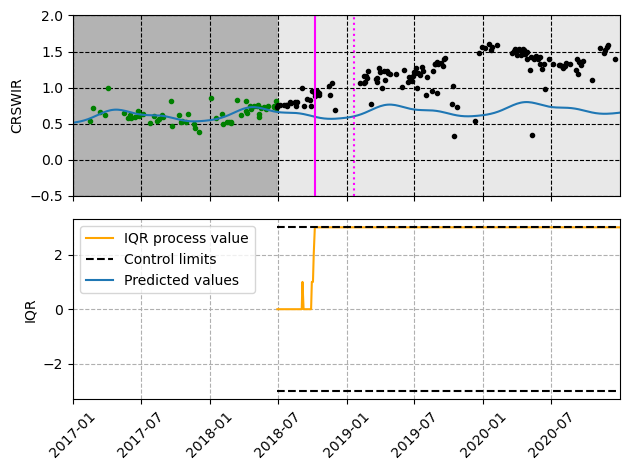

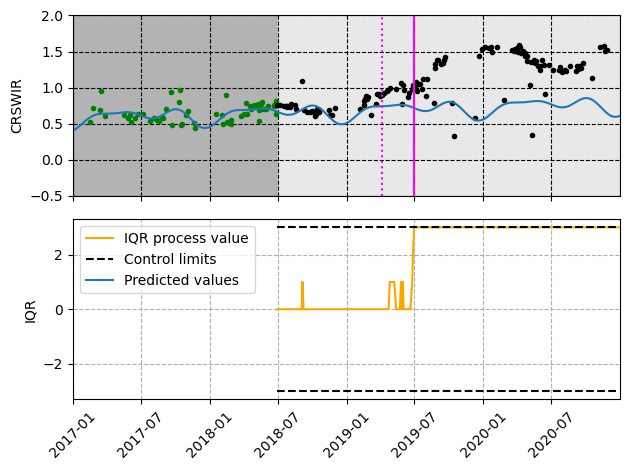

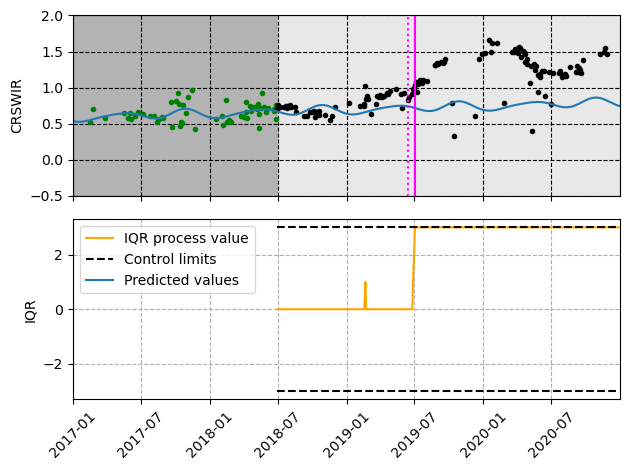

In [12]:
# period dates (yyyy, mm, dd)
d1 = dt.datetime(2017, 1, 1)
d2 = dt.datetime(2018, 6, 30)
d3 = dt.datetime(2020, 12, 31)

list_diff = list()
list_none = 0
for i in range(3):  #for all points, replace with range(len(vector))
    pt = vector.iloc[i]
    pt_x = pt['geometry'].x
    pt_y = pt['geometry'].y
    pt_date = pt['SAMPLE_1']
    my_plot = Nrt_plot(IqrMon, crswir, [d1, d2], [d2, d3],
                       'CRSWIR', 'IQR', ylim=[-0.5, 2],
                       coords=[pt_x, pt_y]
                      )

    my_plot.plot_predict()
    my_plot.plot_break()
    my_plot.plot_date(pt_date)
    my_plot.plot_model()
    # get break date
    monitor_date = my_plot.break_dt
    if monitor_date == 0:
        list_none += 1
    else:
        diff = monitor_date - pt_date
        list_diff.append(diff)

    my_plot.show()

# for saving graph as image file:
# my_plot.savefig('<path>/my_plot.png')

#### 3.1.2. Brief assessment

Here, the assessment of results only relies on the lag between the reference date and the detected date. We therefore assume that all detections are true positives (it is true in this case since we are working on sampling points affected by dieback).

In [13]:
# Assessment based on absolute difference
if len(list_diff) > 0:
    abs_diff = [np.abs(i) for i in list_diff]
    diff_mean = np.mean(abs_diff)
    diff_max = np.max(abs_diff)
    diff_min = np.min(abs_diff)

    print("number of days between reference and detection:\n---")
    print(f"-mean:{diff_mean}\n-min: {diff_min}\n-max: {diff_max}")
    print(f"false negatives:{list_none}")

number of days between reference and detection:
---
-mean:69.0
-min: 17
-max: 105
false negatives:0


For the following parts, except the method, the code is the same. You are welcome to test the different methods with different parameters.

### 3.2. Test 02: EWMA method

#### 3.2.1. Run the EWMA method and plot the results

The first step is to instantiate an EWMA object.

We use the default settings. As a reminder, those of the EWMA method are as follows:
- `trend=True`
- `harmonic_order=2`
- `sensitivity=2`
- `lambda_=0.3`
- `threshold_outlier=10`


In [23]:
EwmaMon = EWMA()

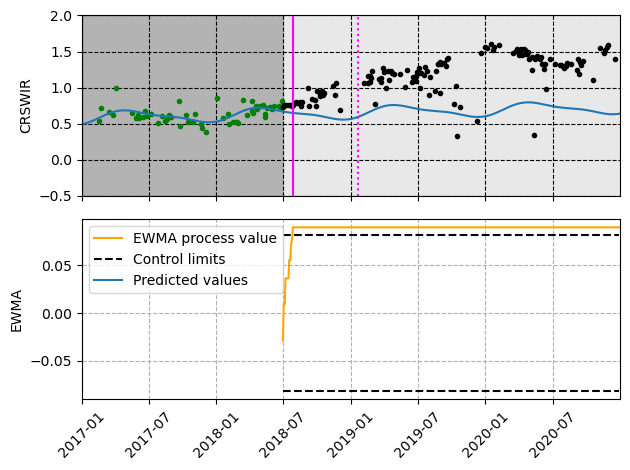

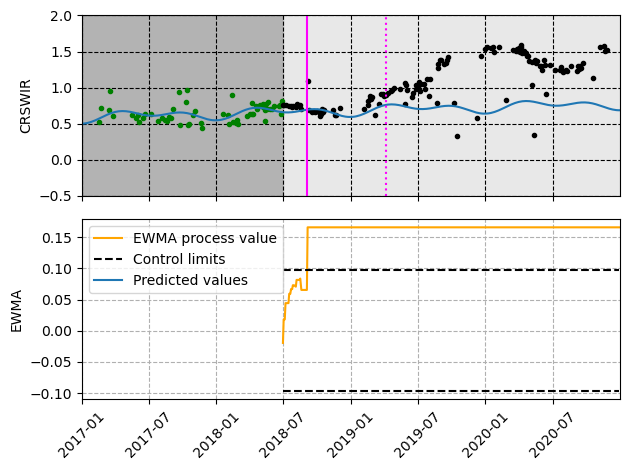

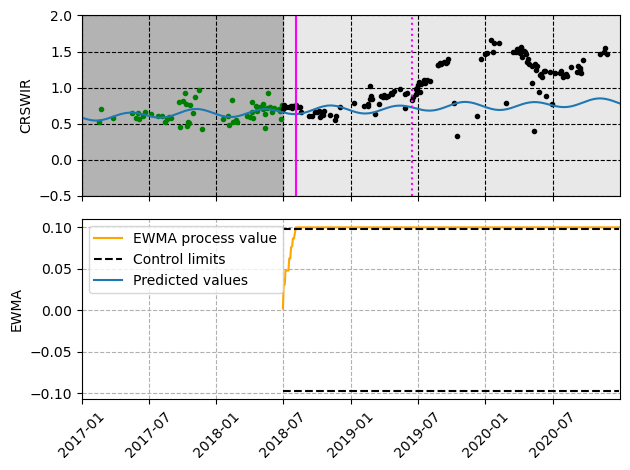

In [24]:
list_diff = list()
list_none = 0
for i in range(3):
    pt = vector.iloc[i]
    pt_x = pt['geometry'].x
    pt_y = pt['geometry'].y
    pt_date = pt['SAMPLE_1']
    my_plot = Nrt_plot(EwmaMon, crswir, [d1, d2], [d2, d3],
                       'CRSWIR', 'EWMA', ylim=[-0.5, 2],
                       coords=[pt_x, pt_y]
                      )

    my_plot.plot_predict()
    my_plot.plot_break()
    my_plot.plot_date(pt_date)
    my_plot.plot_model()
    # get break date
    monitor_date = my_plot.break_dt
    if monitor_date == 0:
        list_none += 1
    else:
        diff = monitor_date - pt_date
        list_diff.append(diff)
    my_plot.show()

# for saving graph as image file:
# my_plot.savefig('<path>/my_plot.png')

3.2.2. Brief assessment

Here, the assessment of results only relies on the lag between the reference date and the detected date. We therefore assume that all detections are true positives (it is true in this case since we are working on sampling points affected by dieback).


In [16]:
# Assessment based on absolute difference
if len(list_diff) > 0:
    abs_diff = [np.abs(i) for i in list_diff]
    diff_mean = np.mean(abs_diff)
    diff_max = np.max(abs_diff)
    diff_min = np.min(abs_diff)

    print("number of days between reference and detection:\n---")
    print(f"-mean:{diff_mean}\n-min: {diff_min}\n-max: {diff_max}")
    print(f"false negatives:{list_none}")

### 3.3. Test 03: CUSUM method

#### 3.3.1. Run the CUSUM method and plot the results

The first step is to instantiate an CUSUM object.

We use the default settings. As a reminder, those of the CUSUM method are as follows:
- `trend=True`
- `harmonic_order=2`
- `sensitivity=0.05`

In [26]:
# Instantiation 
CusumMon = CuSum()

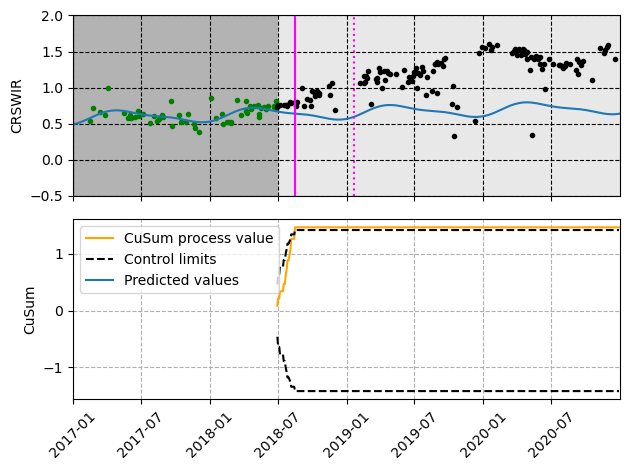

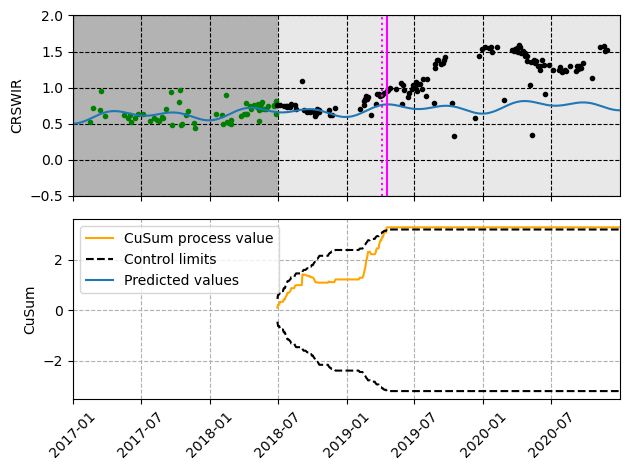

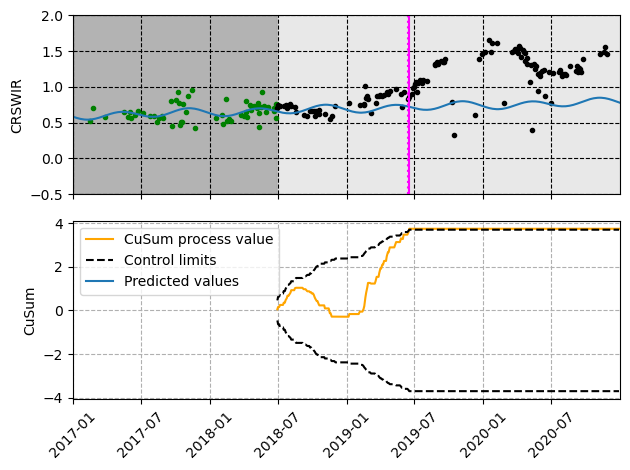

In [27]:
list_diff = list()
list_none = 0
for i in range(3):
    pt = vector.iloc[i]
    pt_x = pt['geometry'].x
    pt_y = pt['geometry'].y
    pt_date = pt['SAMPLE_1']
    my_plot = Nrt_plot(CusumMon, crswir, [d1, d2], [d2, d3],
                       'CRSWIR', 'CuSum', ylim=[-0.5, 2],
                       coords=[pt_x, pt_y]
                      )

    my_plot.plot_predict()
    my_plot.plot_break()
    my_plot.plot_date(pt_date)
    my_plot.plot_model()
    # get break date
    monitor_date = my_plot.break_dt
    if monitor_date == 0:
        list_none += 1
    else:
        diff = monitor_date - pt_date
        list_diff.append(diff)
    my_plot.show()

# for saving graph as image file:
# my_plot.savefig('<path>/my_plot.png')

3.3.2. Brief assessment

Here, the assessment of results only relies on the lag between the reference date and the detected date. We therefore assume that all detections are true positives (it is true in this case since we are working on sampling points affected by dieback).

In [19]:
# Assessment based on absolute difference
if len(list_diff) > 0:
    abs_diff = [np.abs(i) for i in list_diff]
    diff_mean = np.mean(abs_diff)
    diff_max = np.max(abs_diff)
    diff_min = np.min(abs_diff)

    print("number of days between reference and detection:\n---")
    print(f"-mean:{diff_mean}\n-min: {diff_min}\n-max: {diff_max}")
    print(f"false negatives:{list_none}")

number of days between reference and detection:
---
-mean:92.33333333333333
-min: 72
-max: 110
false negatives:0


### 3.4. Test 04: MOSUM method

#### 3.4.1. Run the MOSUM method and plot the results

The first step is to instantiate an MOSUM object.

We use the default settings. As a reminder, those of the MOSUM method are as follows:
- `trend=True`
- `harmonic_order=2`
- `sensitivity=0.05`
- `h=0.25`

In [28]:
MosumMon = MoSum()

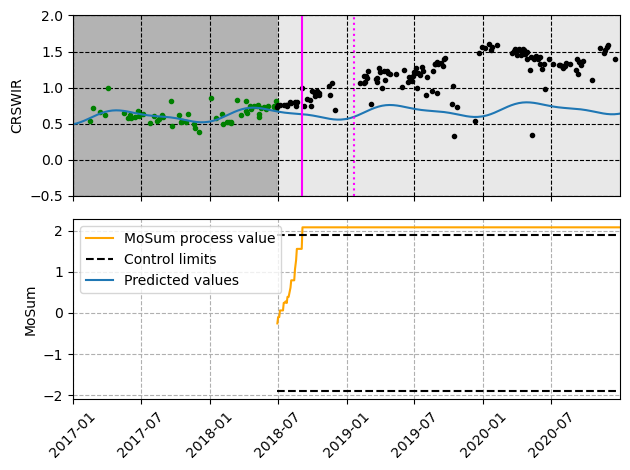

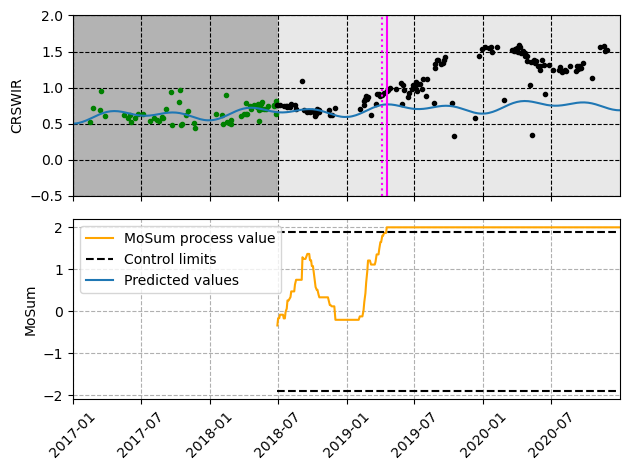

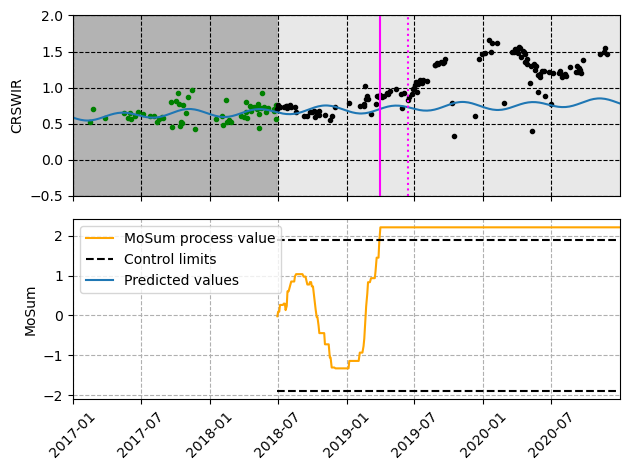

In [44]:
list_diff = list()
list_none = 0
for i in range(3):
    pt = vector.iloc[i]
    pt_x = pt['geometry'].x
    pt_y = pt['geometry'].y
    pt_date = pt['SAMPLE_1']
    my_plot = Nrt_plot(MosumMon, crswir, [d1, d2], [d2, d3],
                       'CRSWIR', 'MoSum', ylim=[-0.5, 2],
                       coords=[pt_x, pt_y]
                      )

    my_plot.plot_predict()
    my_plot.plot_break()
    my_plot.plot_date(pt_date)
    my_plot.plot_model()
    # get break date
    monitor_date = my_plot.break_dt
    if monitor_date == 0:
        list_none += 1
    else:
        diff = monitor_date - pt_date
        list_diff.append(diff)
    my_plot.show()

# for saving graph as image file:
# my_plot.savefig('<path>/my_plot.png')

3.4.2. Brief assessment

Here, the assessment of results only relies on the lag between the reference date and the detected date. We therefore assume that all detections are true positives (it is true in this case since we are working on sampling points affected by dieback).

In [31]:
# Assessment based on absolute difference
if len(list_diff) > 0:
    abs_diff = [np.abs(i) for i in list_diff]
    diff_mean = np.mean(abs_diff)
    diff_max = np.max(abs_diff)
    diff_min = np.min(abs_diff)

    print("number of days between reference and detection:\n---")
    print(f"-mean:{diff_mean}\n-min: {diff_min}\n-max: {diff_max}")
    print(f"false negatives:{list_none}")

number of days between reference and detection:
---
-mean:75.0
-min: 12
-max: 138
false negatives:0


### 3.5. Test 05: CCDC method

#### 3.5.1. Run the CCDC method and plot the results

The first step is to instantiate an CCDC object.

We use the default settings. As a reminder, those of the CCDC method are as follows:
- `trend=True`
- `harmonic_order=2`
- `sensitivity=3`
- `boundary=3`

In [41]:
CcdcMon = CCDC()

In [ ]:
# Instanciation
"""
CcdcMon = CCDC(
    trend=False,
    harmonic_order=2,
    sensitivity=3,
    boundary=3
)
"""

In [42]:
with open('nrt_var.txt', 'rb') as f:
    dict_var = pickle.load(f)

startdate = dict_var['startdate']
enddate = dict_var['enddate']
output_dir = dict_var['output_dir']

array = xr.open_dataset(
    os.path.join(output_dir, f'S2TS_{startdate}-{enddate}.nc')
    )

In [46]:
list_diff = list()
list_none = 0
for i in range(len(vector)):
    pt = vector.iloc[i]
    pt_x = pt['geometry'].x
    pt_y = pt['geometry'].y
    pt_date = pt['SAMPLE_1']

    # --- for ccdc only ---
    green = array.B03.sel(x=[pt_x], y=[pt_y], method='nearest')
    swir = array.B11.sel(x=[pt_x], y=[pt_y], method='nearest')

    cloud_mask = array.SCL.isin([3, 8, 9, 10])

    green_mask = green.where(~cloud_mask)
    swir_mask = swir.where(~cloud_mask)
    
    print(green_mask.dims)
    #green = green.astype(np.int16)
    #swir = swir.astype(np.int16)

    # --- end ---

    my_plot = Nrt_plot(CcdcMon, crswir, [d1, d2], [d2, d3],
                       'CRSWIR', 'CCDC', coords=[pt_x, pt_y], ylim=[-0.5, 2], 
                       green=green_mask, swir=swir_mask,
                       scaling_factor=10000
                      )

    my_plot.plot_predict()
    my_plot.plot_break()
    my_plot.plot_date(pt_date)
    my_plot.plot_model()
    # get break date
    monitor_date = my_plot.break_dt
    if monitor_date == 0:
        list_none += 1
    else:
        diff = monitor_date - pt_date
        list_diff.append(diff)
    my_plot.show()

# for saving graph as image file:
# my_plot.savefig('<path>/my_plot.png')


('time', 'y', 'x')


SystemError: CPUDispatcher(<function rirls at 0x7f499cad3e20>) returned a result with an exception set